## Part 1: Get data from sources

- 1A: Alpha Vantage API


- 1B: Yahoo Finance

In [229]:
import yfinance as yf
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

Define the input symbol. It should received from the user input.

In [230]:
symbol = "TSLA"

Declaration of system configuration

In [231]:
config = {
    "y_finance": {
        "period": "10y", # period to download the data from Yahoo Finance
        "symbol": symbol, # TSLA - Tesla
        "key_adjusted_close": "adj close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Get the data and save to CSV file

In [232]:
# Get data of a period of recent years
df = yf.download(symbol, period=config['y_finance']['period'])

# Save the data to CSV file
df.to_csv('data/' + symbol + '.csv')

[*********************100%%**********************]  1 of 1 completed


Load data from CSV file for processing

In [463]:
# Loading data from CSV file
df = pd.read_csv('data/' + symbol + '.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500
1,2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000
2,2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500
3,2013-09-12,10.933333,11.117333,10.700667,10.995333,10.995333,92400000
4,2013-09-13,10.851333,11.091333,10.810667,11.036000,11.036000,81018000


## Part 2: EDA

In [464]:
# Change column names to lower case to process easier in latter parts
df.columns = df.columns.str.lower()

Handle missing values


In [465]:
df.isnull().sum()

date         0
open         0
high         0
low          0
close        0
adj close    0
volume       0
dtype: int64

Note:
- No missing values

Handle duplicated values

In [352]:
duplicated_rows = df.duplicated().sum()
duplicated_rows

0

Note:
- No duplicated values

In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2517 non-null   object 
 1   open       2517 non-null   float64
 2   high       2517 non-null   float64
 3   low        2517 non-null   float64
 4   close      2517 non-null   float64
 5   adj close  2517 non-null   float64
 6   volume     2517 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


Change `date` to index of time series

In [466]:
df.set_index(pd.DatetimeIndex(df['date']), inplace = True)

In [355]:
df.head()

,date,open,high,low,close,adj close,volume
date,,,,,,,
2013-09-09,2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500
2013-09-10,2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000
2013-09-11,2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500
2013-09-12,2013-09-12,10.933333,11.117333,10.700667,10.995333,10.995333,92400000
2013-09-13,2013-09-13,10.851333,11.091333,10.810667,11.036000,11.036000,81018000


In [467]:
df = df.drop(columns=['date'], axis=1)

In [357]:
num_feats = ['open', 'high', 'low', 'close', 'adj close', 'volume']

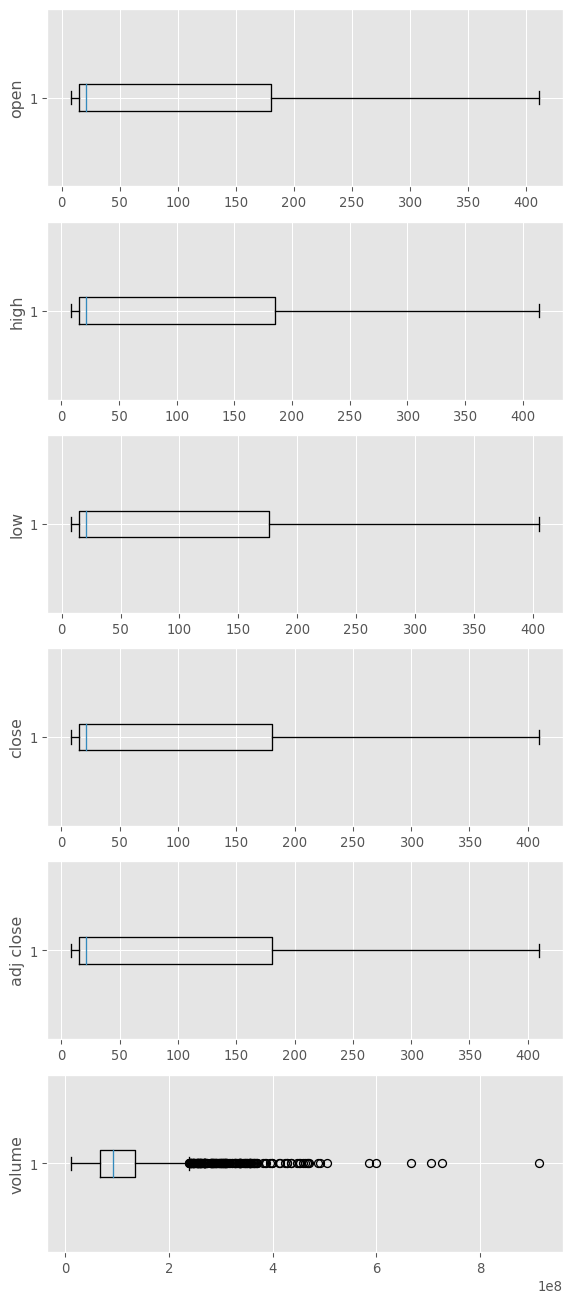

In [358]:
# Box Plots
fig, axs = plt.subplots(len(num_feats),1,dpi=95, figsize=(7,17))
i = 0
for feat in num_feats:
    axs[i].boxplot(df[feat], vert=False)
    axs[i].set_ylabel(feat)
    i+=1

plt.show()

Note:
- We can see that there are bunch of outliers at `Volume` feature

In [468]:
# Function to detect outliers using interquatile
def detect_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = dataframe[(dataframe[column] < Q1 - 1.5*IQR) | (dataframe[column] > Q3 + 1.5*IQR)]
    return outliers

# Detect and print number of outliers for each feature
for column in num_feats:
    outliers = detect_outliers(df, column)
    print(f'Number of outliers in {column}: {len(outliers)}')

Number of outliers in open: 0
Number of outliers in high: 0
Number of outliers in low: 0
Number of outliers in close: 0
Number of outliers in adj close: 0
Number of outliers in volume: 174


In [469]:
# Function to handle outliers by setting their values into the threshold
def handle_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    dataframe[column] = dataframe[column].apply(lambda x: upper_limit if x > upper_limit else lower_limit if x < lower_limit else x)

# Handle outliers for each feature
for column in num_feats:
    handle_outliers(df, column)

# Checking the outliers after correct
for column in num_feats:
    outliers = detect_outliers(df, column)
    print(f'Number of outliers in {column}: {len(outliers)}')

Number of outliers in open: 0
Number of outliers in high: 0
Number of outliers in low: 0
Number of outliers in close: 0
Number of outliers in adj close: 0
Number of outliers in volume: 0


Note:
- There is no more outliers in the `volume` feature

In [470]:
df.describe()

,open,high,low,close,adj close,volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,86.801564,88.740096,84.707496,86.777275,86.777275,1.085466e+08
std,106.112565,108.525796,103.433150,106.016894,106.016894,5.682278e+07
min,7.958667,8.181333,7.740000,8.033333,8.033333,1.062000e+07
25%,15.333333,15.571333,15.074667,15.334000,15.334000,6.643230e+07
50%,20.932667,21.242001,20.600000,20.994667,20.994667,9.286500e+07
75%,180.133331,185.100006,176.350006,180.589996,180.589996,1.353465e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,2.387178e+08


In [362]:
df.shape

(2517, 6)

Summary EDA: 
- There are 1257 data points, each data points has 7 features
- 1 feature is datetime, the other 6 features are numerical
- There are some outliers in `volume` feature, using data cleaning technique to set the value within an appropriate threshold
- There is no missing nor duplicated values

## Part 3. Price Prediction using Regression, KNN

In [471]:
import pandas_ta

# Add EMA_10 to the dataframe
df.ta.ema(close='adj close', length = 10, append = True)

date
2013-09-09           NaN
2013-09-10           NaN
2013-09-11           NaN
2013-09-12           NaN
2013-09-13           NaN
                 ...    
2023-08-31    245.240272
2023-09-01    245.198403
2023-09-05    247.251419
2023-09-06    248.100252
2023-09-07    248.422023
Name: EMA_10, Length: 2517, dtype: float64

In [364]:
df

,open,high,low,close,adj close,volume,EMA_10
date,,,,,,,
2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0,NaN
2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000.0,NaN
2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500.0,NaN
2013-09-12,10.933333,11.117333,10.700667,10.995333,10.995333,92400000.0,NaN
2013-09-13,10.851333,11.091333,10.810667,11.036000,11.036000,81018000.0,NaN
...,...,...,...,...,...,...,...
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700.0,245.240272
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500.0,245.198403
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600.0,247.251419


In [472]:
# Drop the first n-rows
df = df.iloc[10:]
# View our newly-formed dataset
print(df.head(10))

                 open       high        low      close  adj close  \
date                                                                
2013-09-23  12.298667  12.365333  11.807333  12.074000  12.074000   
2013-09-24  11.942667  12.330667  11.843333  12.155333  12.155333   
2013-09-25  12.237333  12.420000  12.033333  12.349333  12.349333   
2013-09-26  12.446667  12.645333  12.374000  12.576000  12.576000   
2013-09-27  12.501333  12.752000  12.428667  12.726667  12.726667   
2013-09-30  12.600000  12.966667  12.533333  12.891333  12.891333   
2013-10-01  12.930667  12.948667  12.558000  12.866667  12.866667   
2013-10-02  12.572667  12.788667  11.693333  12.063333  12.063333   
2013-10-03  11.670000  11.979333  11.200000  11.554000  11.554000   
2013-10-04  11.760000  12.078667  11.510000  12.065333  12.065333   

                 volume     EMA_10  
date                                
2013-09-23  122601000.0  11.366545  
2013-09-24   94101000.0  11.509961  
2013-09-25  123790500.0

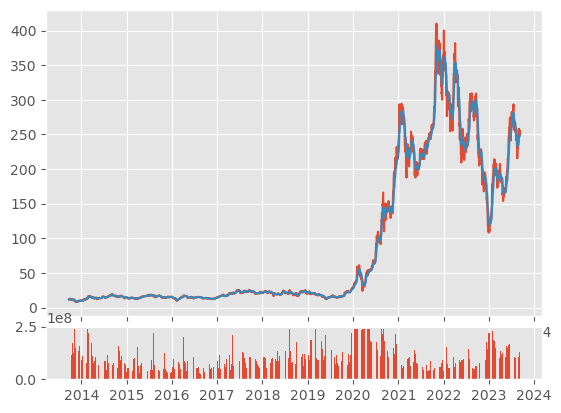

In [473]:
from matplotlib import style
style.use('ggplot')

ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)
ax1.plot(df.index,df['adj close'])
ax1.plot(df.index,df['EMA_10'])
ax2.bar(df.index,df['volume'])

plt.show()

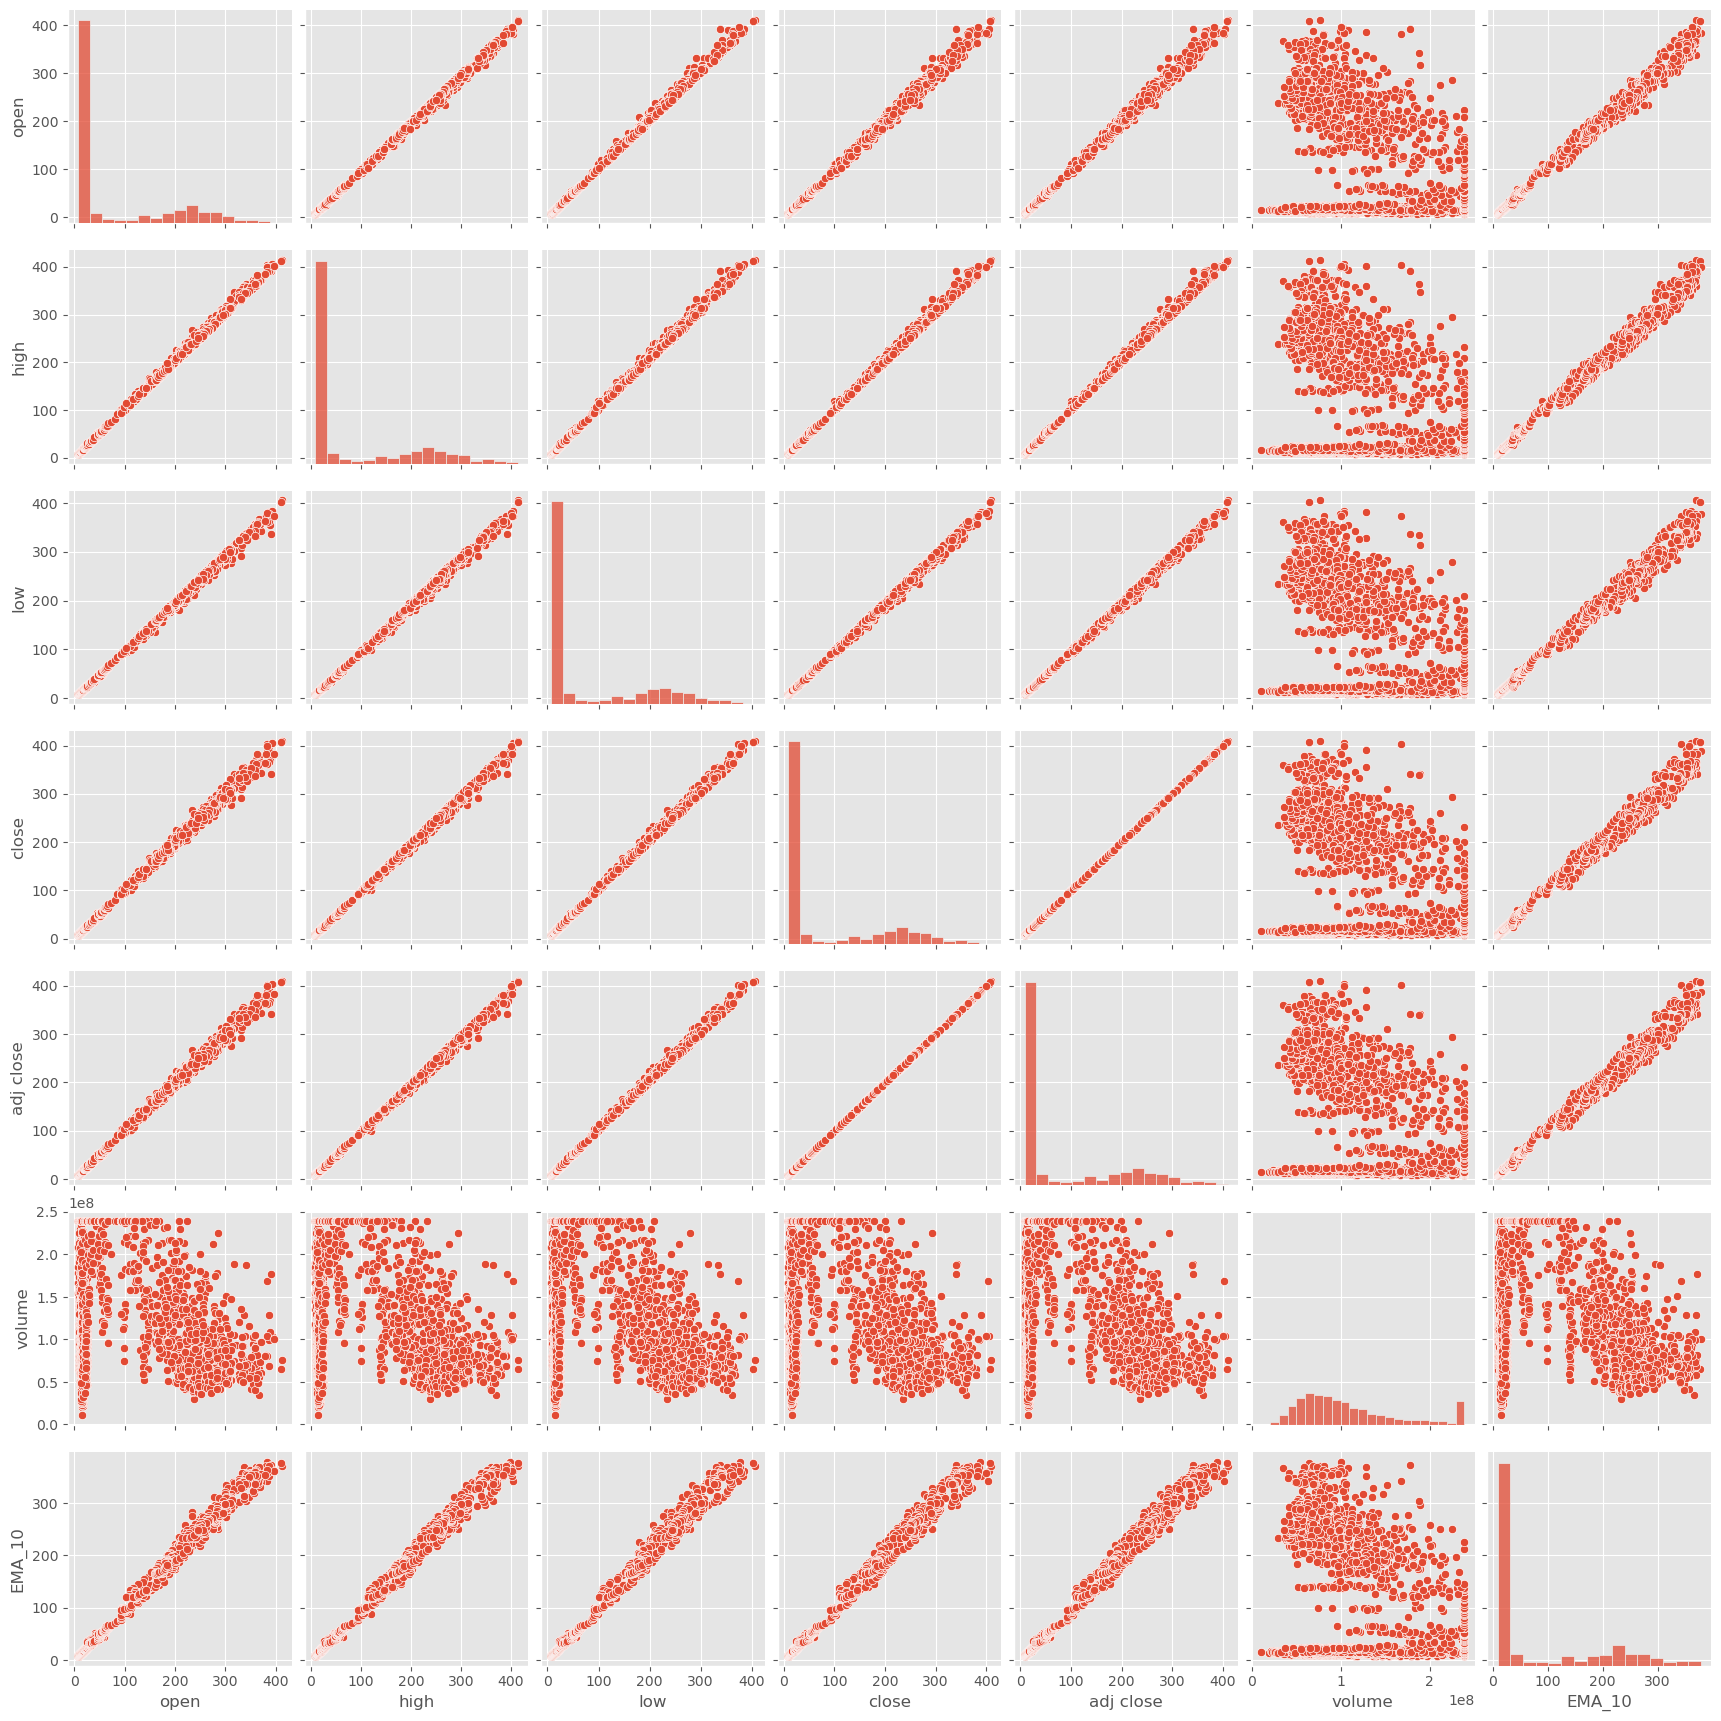

In [367]:
sns.pairplot(df)

## Feature Engineering

In [474]:
# It looks like volume has no correlation with "adj close"
# Therefore, we remove it out of the feaures
df_reg = df.loc[:,['open', 'high', 'low', 'close', 'adj close', 'EMA_10']]
df_reg.head()

,open,high,low,close,adj close,EMA_10
date,,,,,,
2013-09-23,12.298667,12.365333,11.807333,12.074000,12.074000,11.366545
2013-09-24,11.942667,12.330667,11.843333,12.155333,12.155333,11.509961
2013-09-25,12.237333,12.420000,12.033333,12.349333,12.349333,11.662574
2013-09-26,12.446667,12.645333,12.374000,12.576000,12.576000,11.828652
2013-09-27,12.501333,12.752000,12.428667,12.726667,12.726667,11.991927


In [409]:
df.shape

(2507, 7)

In [370]:
df_reg.shape

(2507, 6)

Train Test Split Data

Use a `(70%, 20%, 10%)` split for the training, validation, and test sets

In [143]:
# import math
# import numpy as np
# from sklearn import preprocessing, svm

# # Drop missing value
# df_reg.fillna(value=-99999, inplace=True)

# # We want to separate 1 percent of the data to forecast
# forecast_out = int(math.ceil(0.01 * len(df_reg)))

# # Separating the label here, we want to predict the values of adj close
# forecast_col = 'adj close'
# df_reg['forecast price'] = df_reg[forecast_col].shift(-forecast_out)

# X = np.array(df_reg.drop(['forecast price'], axis=1))

# # Scale the X so that everyone can have the same distribution for linear regression
# X = preprocessing.scale(X)

# # Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
# X_lately = X[-forecast_out:]
# X = X[:-forecast_out]

# # Separate label and identify it as y
# y = np.array(df_reg['forecast price'])
# y = y[:-forecast_out]

# print('Forecast price \n', df_reg['forecast price'].tail(30))
# print('Dimension of X',X.shape)
# print('Dimension of y',y.shape)
# print('Dimension of df_reg', df_reg.shape)

Target data 
 date
2023-07-26    258.079987
2023-07-27    245.009995
2023-07-28    256.489990
2023-07-31    251.919998
2023-08-01           NaN
2023-08-02           NaN
2023-08-03           NaN
2023-08-04           NaN
2023-08-07           NaN
2023-08-08           NaN
2023-08-09           NaN
2023-08-10           NaN
2023-08-11           NaN
2023-08-14           NaN
2023-08-15           NaN
2023-08-16           NaN
2023-08-17           NaN
2023-08-18           NaN
2023-08-21           NaN
2023-08-22           NaN
2023-08-23           NaN
2023-08-24           NaN
2023-08-25           NaN
2023-08-28           NaN
2023-08-29           NaN
2023-08-30           NaN
2023-08-31           NaN
2023-09-01           NaN
2023-09-05           NaN
2023-09-06           NaN
Name: target, dtype: float64
Dimension of X (2480, 4)
Dimension of y (2480,)
Dimension of df_reg (2506, 5)


In [475]:
import math
import numpy as np
from sklearn import preprocessing, svm

# Drop missing value
df_reg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(df_reg)))

# Separating the label here, we want to predict the values of adj close
forecast_col = 'adj close'
df_reg['forecast price'] = df_reg[forecast_col].shift(-forecast_out)

X = np.array(df_reg.drop(['forecast price'], axis=1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_unseen = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(df_reg['forecast price'])
y = y[:-forecast_out]

print('Forecast price \n', df_reg.tail(20))
print('Dimension of X',X.shape)
print('Dimension of y',y.shape)
print('Dimension of df_reg', df_reg.shape)

Forecast price 
                   open        high         low       close   adj close  \
date                                                                     
2023-08-10  245.399994  251.800003  243.000000  245.339996  245.339996   
2023-08-11  241.770004  243.789993  238.020004  242.649994  242.649994   
2023-08-14  235.699997  240.660004  233.750000  239.759995  239.759995   
2023-08-15  238.729996  240.500000  232.610001  232.960007  232.960007   
2023-08-16  228.020004  233.970001  225.380005  225.600006  225.600006   
2023-08-17  226.059998  226.740005  218.830002  219.220001  219.220001   
2023-08-18  214.119995  217.580002  212.360001  215.490005  215.490005   
2023-08-21  221.550003  232.130005  220.580002  231.279999  231.279999   
2023-08-22  240.250000  240.820007  229.550003  233.190002  233.190002   
2023-08-23  229.339996  238.979996  229.289993  236.860001  236.860001   
2023-08-24  238.660004  238.919998  228.179993  230.039993  230.039993   
2023-08-25  231.30999

In [411]:
# import math
# import numpy as np
# from sklearn import preprocessing, svm

# # Drop missing value
# df_reg.fillna(value=-99999, inplace=True)

# # We want to separate 1 percent of the data to forecast
# forecast_out = int(math.ceil(0.01 * len(df_reg)))

# # Separating the label here, we want to predict the values of adj close
# forecast_col = 'adj close'
# # df_reg['forecast price'] = df_reg[forecast_col].shift(-forecast_out)

# X = np.array(df_reg.drop(['EMA_10'], axis=1))

# # Scale the X so that everyone can have the same distribution for linear regression
# X = preprocessing.scale(X)

# # Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
# X_unseen = X[-forecast_out:]
# X = X[:-forecast_out]

# # Separate label and identify it as y
# y = np.array(df_reg['EMA_10'])
# y = y[:-forecast_out]

# print('Forecast price \n', df_reg.tail(20))
# print('Dimension of X',X.shape)
# print('Dimension of y',y.shape)
# print('Dimension of df_reg', df_reg.shape)

In [390]:
print(X_unseen.shape)

(26, 7)


In [476]:
from sklearn.model_selection import train_test_split
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [477]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1984, 6) (497, 6) (1984,) (497,)


## Model Generation

To predict the return of the stocks in the next period - Prediction analysis

- Simple Linear Analysis
- Quadratic Linear Analysis (QDA)
- K Nearest Neighbor (KNN

In [478]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clf_reg = LinearRegression()
clf_reg.fit(X_train, y_train)


# Quadratic Regression 2
clf_poly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clf_poly2.fit(X_train, y_train)

# Quadratic Regression 3
clf_poly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clf_poly3.fit(X_train, y_train)
    
# KNN Regression
clf_knn = KNeighborsRegressor(n_neighbors=2)
clf_knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [479]:
confidence_reg = clf_reg.score(X_test, y_test)
confidence_poly2 = clf_poly2.score(X_test,y_test)
confidence_poly3 = clf_poly3.score(X_test,y_test)
confidence_knn = clf_knn.score(X_test, y_test)

print("The linear regression confidence is ",confidence_reg)
print("The quadratic regression 2 confidence is ",confidence_poly2)
print("The quadratic regression 3 confidence is ",confidence_poly3)
print("The knn regression confidence is ",confidence_knn)

The linear regression confidence is  0.9249809155112075
The quadratic regression 2 confidence is  0.9376765571949964
The quadratic regression 3 confidence is  0.9395568468854615
The knn regression confidence is  0.9475193953055894


Model Evaluation

In [481]:
# Import metrics from sklearn for evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predict the values
y_pred_lr = clf_reg.predict(X_test)
y_pred_rr2 = clf_poly2.predict(X_test)
y_pred_rr3 = clf_poly3.predict(X_test)
y_pred_knn = clf_knn.predict(X_test)

In [482]:
# Print metrics of linear regression
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_lr))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_lr))
print("Coefficient of Determination:", r2_score(y_test, y_pred_lr))

Mean Squared Error: 865.7970770067448
Mean Absolute Error: 16.414342576607563
Coefficient of Determination: 0.9249809155112075


In [483]:
# Print metrics of Ridge regression 2
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_rr2))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_rr2))
print("Coefficient of Determination:", r2_score(y_test, y_pred_rr2))

Mean Squared Error: 719.2763678371803
Mean Absolute Error: 14.14907223319756
Coefficient of Determination: 0.9376765571949964


In [484]:
# Print metrics of Ridge regression 3
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_rr3))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_rr3))
print("Coefficient of Determination:", r2_score(y_test, y_pred_rr3))

Mean Squared Error: 697.5758988295405
Mean Absolute Error: 14.020960829308748
Coefficient of Determination: 0.9395568468854615


In [485]:
# Print metrics of KNN
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_knn))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_knn))
print("Coefficient of Determination:", r2_score(y_test, y_pred_knn))

Mean Squared Error: 605.679934027393
Mean Absolute Error: 11.99972449557882
Coefficient of Determination: 0.9475193953055894


Note
- Ridge Regression 2 has the best performance compared to the others because it has less errors and high coefficient of determination.
- But, the error is still really high

Make prediction with unseen data

In [486]:
# Printing the forecast
forecast_set = clf_poly2.predict(X_unseen)
df_reg['forecast'] = np.nan
print(forecast_set, confidence_reg, forecast_out)

[252.70326851 257.21329972 254.26058906 253.00063661 250.24409104
 245.6254469  248.09164877 246.20751455 243.96139524 239.33741868
 232.95005395 228.90297415 225.24843279 241.32518945 245.28590933
 246.49572936 242.16605296 248.19891972 249.45793119 266.10563243
 264.06593569 263.15017025 254.27140999 261.51971662 258.27307783
 254.23110721] 0.9249809155112075 26


## Plotting the Prediction

In [487]:
from datetime import datetime as dt, timedelta

last_date = df_reg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += timedelta(days=1)
    df_reg.loc[next_date] = [np.nan for _ in range(len(df_reg.columns)-1)]+[i]

In [287]:
# df_reg = df_reg.drop('forecast', axis = 1)

In [288]:
df_reg.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'EMA_10',
       'forecast price'],
      dtype='object')

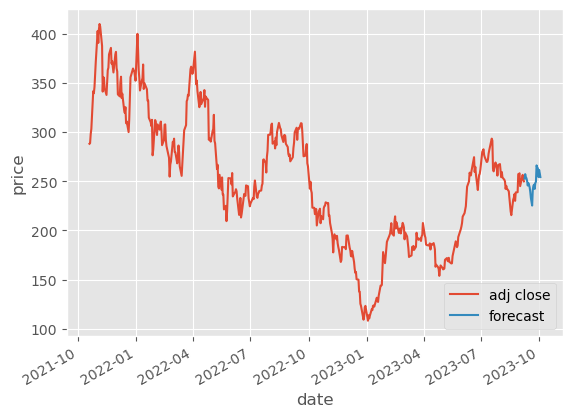

In [488]:
df_reg['adj close'].tail(500).plot()
df_reg['forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('date')
plt.ylabel('price')
plt.show()

In [341]:
df_reg.tail(30)

,open,high,low,close,adj close,EMA_10,forecast price,forecast
date,,,,,,,,
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,245.198403,NaN,NaN
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,247.251419,NaN,NaN
2023-09-06,255.139999,255.389999,245.059998,251.919998,251.919998,248.100252,NaN,NaN
2023-09-07,245.070007,250.740005,243.264999,249.869995,249.869995,248.422023,NaN,NaN
2023-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.302315
2023-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.610905
2023-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.141842
2023-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.718466
2023-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.001366


XGBoost to identify Buy or Sell

In [489]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [490]:
df

,open,high,low,close,adj close,volume,EMA_10
date,,,,,,,
2013-09-23,12.298667,12.365333,11.807333,12.074000,12.074000,122601000.0,11.366545
2013-09-24,11.942667,12.330667,11.843333,12.155333,12.155333,94101000.0,11.509961
2013-09-25,12.237333,12.420000,12.033333,12.349333,12.349333,123790500.0,11.662574
2013-09-26,12.446667,12.645333,12.374000,12.576000,12.576000,99216000.0,11.828652
2013-09-27,12.501333,12.752000,12.428667,12.726667,12.726667,88746000.0,11.991927
...,...,...,...,...,...,...,...
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700.0,245.240272
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500.0,245.198403
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600.0,247.251419


In [491]:
df_xgboost = df.copy()

In [492]:
df_xgboost

,open,high,low,close,adj close,volume,EMA_10
date,,,,,,,
2013-09-23,12.298667,12.365333,11.807333,12.074000,12.074000,122601000.0,11.366545
2013-09-24,11.942667,12.330667,11.843333,12.155333,12.155333,94101000.0,11.509961
2013-09-25,12.237333,12.420000,12.033333,12.349333,12.349333,123790500.0,11.662574
2013-09-26,12.446667,12.645333,12.374000,12.576000,12.576000,99216000.0,11.828652
2013-09-27,12.501333,12.752000,12.428667,12.726667,12.726667,88746000.0,11.991927
...,...,...,...,...,...,...,...
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700.0,245.240272
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500.0,245.198403
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600.0,247.251419


In [493]:
def classificator(value):
    if value < 0:
        return 'Buy'
    elif value > 0:
        return 'Sell'
    else:
        return 'Hold'

In [499]:
df_xgboost['action'] = df_xgboost['EMA_10'] - df_xgboost['adj close']

In [500]:
df_xgboost

,open,high,low,close,adj close,volume,EMA_10,action
date,,,,,,,,
2013-09-23,12.298667,12.365333,11.807333,12.074000,12.074000,122601000.0,11.366545,-0.707455
2013-09-24,11.942667,12.330667,11.843333,12.155333,12.155333,94101000.0,11.509961,-0.645371
2013-09-25,12.237333,12.420000,12.033333,12.349333,12.349333,123790500.0,11.662574,-0.686759
2013-09-26,12.446667,12.645333,12.374000,12.576000,12.576000,99216000.0,11.828652,-0.747349
2013-09-27,12.501333,12.752000,12.428667,12.726667,12.726667,88746000.0,11.991927,-0.734740
...,...,...,...,...,...,...,...,...
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700.0,245.240272,-12.839715
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500.0,245.198403,0.188409
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600.0,247.251419,-9.238571


In [501]:
df_xgboost['action'] = df_xgboost['action'].apply(classificator)

In [548]:
# convert 'action' column to numeric
df_xgboost['action'] = pd.factorize(df_xgboost['action'])[0]

In [504]:
df_xgboost['action'].value_counts()

0    1408
1    1099
Name: action, dtype: int64

In [523]:
# Split the data into input features (X) and target variable (y)
X = df_xgboost.drop('action', axis=1)
y = df_xgboost['action']

Handle imbalanced dataset using SMOTE

<Axes: ylabel='action'>

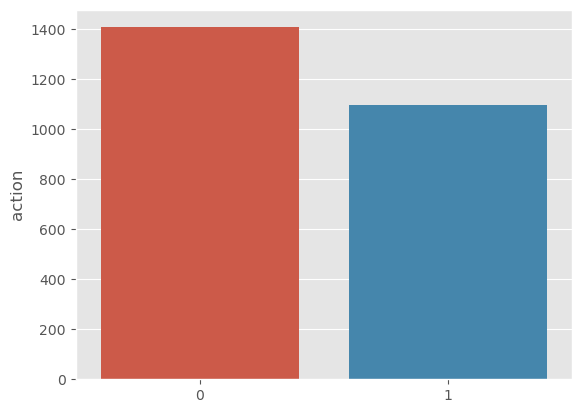

In [551]:
sns.barplot(y=y.value_counts(), x=[0,1])

In [527]:
from imblearn.over_sampling import SMOTE

In [528]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

In [529]:

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (2507, 7)
Shape of X after SMOTE: (2816, 7)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: action, dtype: float64

In [531]:
y_sm.value_counts()

0    1408
1    1408
Name: action, dtype: int64

<Axes: ylabel='action'>

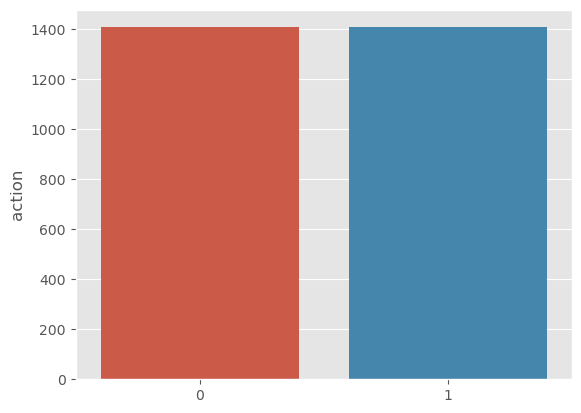

In [550]:
sns.barplot(y=y_sm.value_counts(), x=[0,1])

In [532]:
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

In [533]:

# Convert the training and testing data to DMatrix format
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 3,
    'eta': 0.1
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

In [534]:
# Make predictions on the testing data
y_pred = xgb_model.predict(dtest)

# Calculate the accuracy of model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8674556213017751


In [535]:
# Other evaluations
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, cohen_kappa_score, log_loss
import matplotlib.pyplot as plt

In [536]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

# Generate a classification report
cr = classification_report(y_test, y_pred)
print(f'Classification Report:\n{cr}')

# Calculate Cohen's Kappa score
kappa = cohen_kappa_score(y_test, y_pred)
print(f'Cohen\'s Kappa Score: {kappa: .2f}')

# Calculate the Log loss
# y_pred_prob = xgb_model.predict(dtest, output_margin=True)
# threshold = (y_pred_prob.min(), y_pred_prob.max())
# logloss = log_loss(y_test, y_pred_prob)
# print(f'Log Loss: {logloss: .2f}')

Confusion Matrix:
[[367  57]
 [ 55 366]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       424
           1       0.87      0.87      0.87       421

    accuracy                           0.87       845
   macro avg       0.87      0.87      0.87       845
weighted avg       0.87      0.87      0.87       845

Cohen's Kappa Score:  0.73


## Part 4. Calculating Support & Resistance in Python using K-Means Clustering

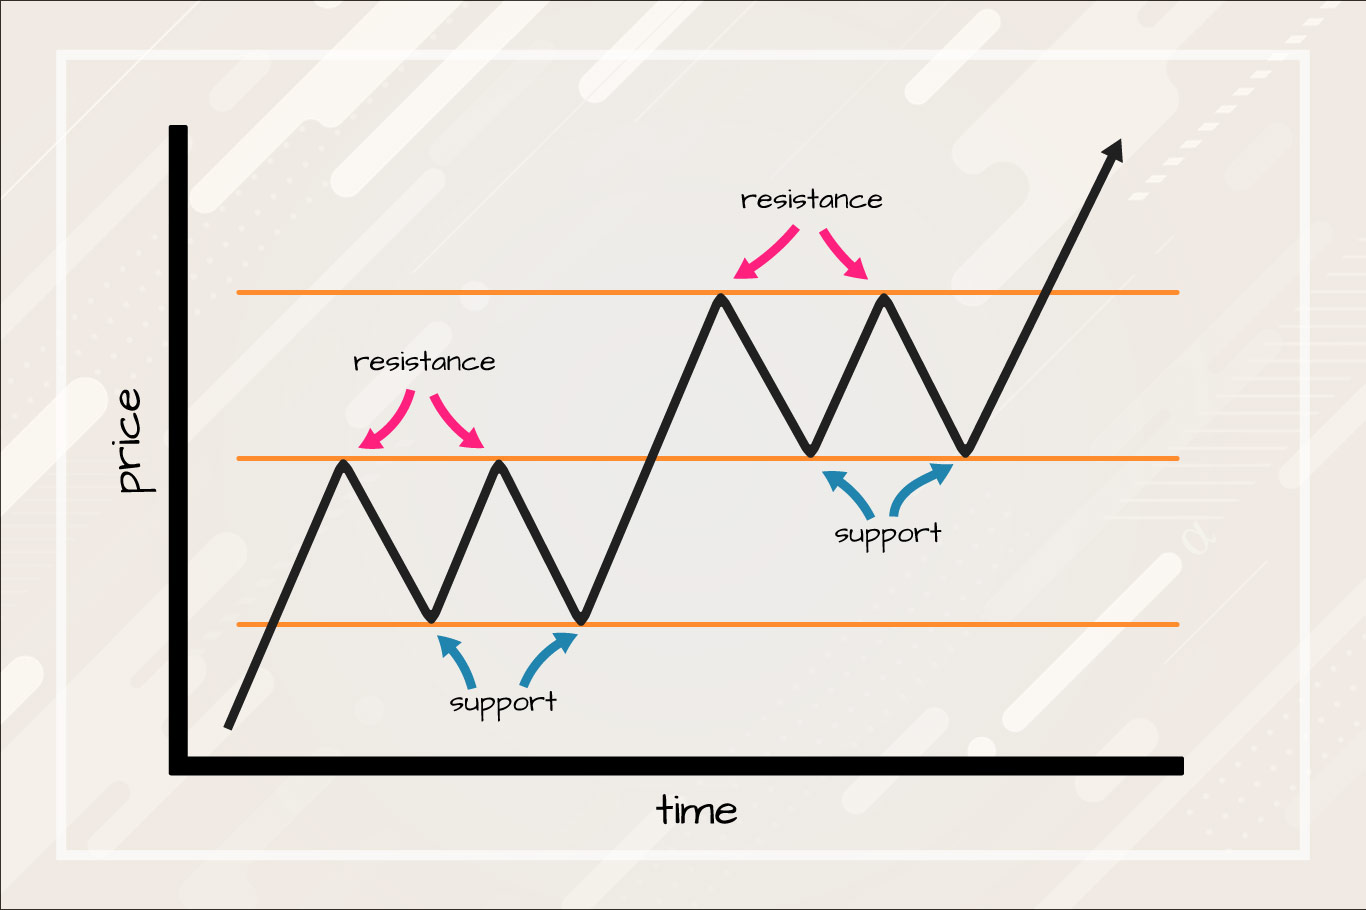

In [555]:
# import Kmeans 
from sklearn.cluster import KMeans

In [553]:
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)
        
    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

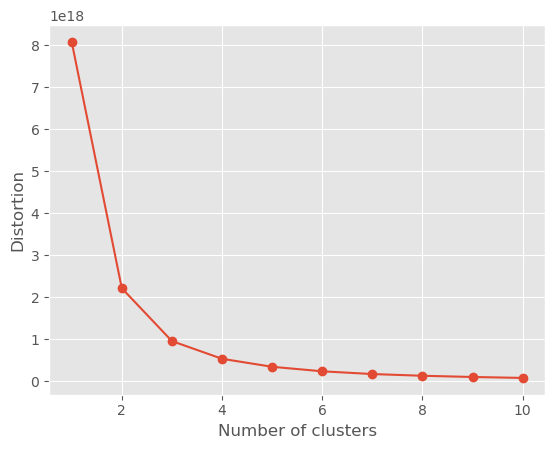

In [556]:
plot_distortion(X,max_clusters=10)

In [ ]:
df = df.set_index('date')

In [557]:
from sklearn.cluster import KMeans

# Convert adjusted closing price to numpy array
symbol_prices = np.array(df["adj close"])
print("Symbol Prices:\n", symbol_prices)
# Perform cluster analysis
K = 6
kmeans = KMeans(n_clusters=3).fit(symbol_prices.reshape(-1, 1))
# predict which cluster each price is in
clusters = kmeans.predict(symbol_prices.reshape(-1, 1))
print("Clusters:\n", clusters)

Symbol Prices:
 [ 12.07400036  12.15533257  12.34933281 ... 256.48999023 251.91999817
 249.86999512]


c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clusters:
 [0 0 0 ... 1 1 1]


In [558]:
import plotly.graph_objects as go

# Assigns plotly as visualization engine
pd.options.plotting.backend = 'plotly'
# Arbitrarily 6 colors for our 6 clusters
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo']
# Create Scatter plot, assigning each point a color based
# on it's grouping where group_number == index of color.
fig = df.plot.scatter(
    x=df.index,
    y="adj close",
    color=[colors[i] for i in clusters],
)
# Configure some styles
layout = go.Layout(
    plot_bgcolor='#efefef',
    showlegend=False,
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)
fig.update_layout(layout)
# Display plot in local browser window
fig.show()

Find Cluster Minimum & Maximum Values

In [559]:
# Create list to hold values, initialized with infinite values
min_max_values = []
# init for each cluster group
for i in range(6):
    # Add values for which no price could be greater or less
    min_max_values.append([np.inf, -np.inf])
# Print initial values
print(min_max_values)
# Get min/max for each cluster
for i in range(len(symbol_prices)):
    # Get cluster assigned to price
    cluster = clusters[i]
    # Compare for min value
    if symbol_prices[i] < min_max_values[cluster][0]:
        min_max_values[cluster][0] = symbol_prices[i]
    # Compare for max value
    if symbol_prices[i] > min_max_values[cluster][1]:
        min_max_values[cluster][1] = symbol_prices[i]
# Print resulting values
print(min_max_values)

[[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf]]
[[8.033332824707031, 106.15533447265624], [246.2833404541016, 409.9700012207031], [108.06666564941406, 246.0666656494141], [inf, -inf], [inf, -inf], [inf, -inf]]


In [560]:
import plotly.graph_objects as go
# Again, assign an arbitrary color to each of the 6 clusters
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo']
# Create Scatter plot, assigning each point a color where
# point group = color index.
fig = df.plot.scatter(
    x=df.index,
    y="adj close",
    color=[colors[i] for i in clusters],
)

# fig = go.Figure(
#     data=go.Scatter(x=df.index,y=df['adj close'], mode='lines+markers')
#     # color=[colors[i] for i in clusters],
#     )
# Add horizontal lines
for cluster_min, cluster_max in min_max_values:
    fig.add_hline(y=cluster_min, line_width=1, line_color="blue")
    fig.add_hline(y=cluster_max, line_width=1, line_color="blue")
# Add a trace of the price for better clarity
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['adj close'],
    line_color="black",
    line_width=1
))
# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    showlegend=False,
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)
fig.update_layout(layout)
fig.show()

## Part 5. Cross check Prediction Using LSTM : A Time-Series model

In [552]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

NameError: name 'Sequential' is not defined

In [ ]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:1600, 1:2]
dataset_test = df.iloc[1600:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



In [ ]:
df = df.reset_index()

ValueError: x and y must have same first dimension, but have shapes (918,) and (459, 1)

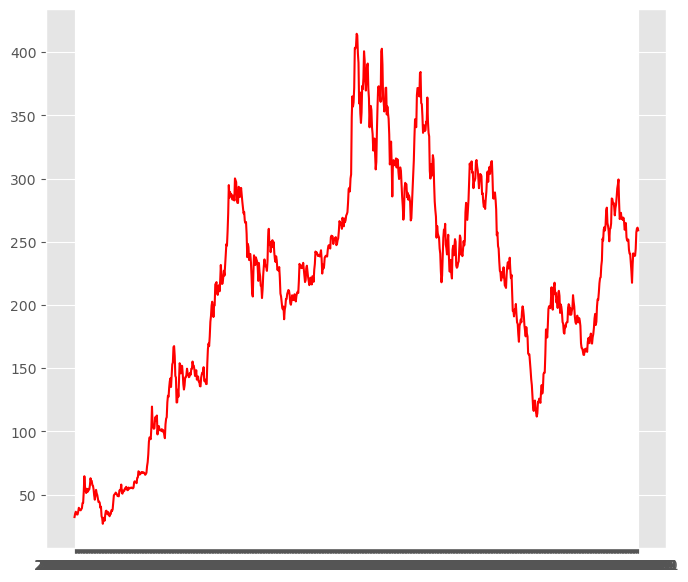

In [ ]:
# Visualising the results
plt.plot(df.loc[1600:, 'date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1600:, 'date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

## Part 6: adding Semantic Analysis to predict Stock Price

## Conclusion

In [192]:
df

,open,high,low,close,adj close,volume,EMA_10,SMA_10
date,,,,,,,,
2013-09-23,12.298667,12.365333,11.807333,12.074000,12.074000,122601000.0,11.366545,11.345400
2013-09-24,11.942667,12.330667,11.843333,12.155333,12.155333,94101000.0,11.509961,11.451800
2013-09-25,12.237333,12.420000,12.033333,12.349333,12.349333,123790500.0,11.662574,11.596600
2013-09-26,12.446667,12.645333,12.374000,12.576000,12.576000,99216000.0,11.828652,11.754667
2013-09-27,12.501333,12.752000,12.428667,12.726667,12.726667,88746000.0,11.991927,11.923733
...,...,...,...,...,...,...,...,...
2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0,242.387002,235.756999
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700.0,245.240272,239.642998
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500.0,245.198403,242.594997


C:\Users\thong.lam\AppData\Local\Temp\ipykernel_35052\4292452255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['action'] = df['EMA_10'] - df['adj close']


In [205]:
df.drop('action', axis = 1)

,open,high,low,close,adj close,volume,EMA_10,SMA_10
date,,,,,,,,
2013-09-23,12.298667,12.365333,11.807333,12.074000,12.074000,122601000.0,11.366545,11.345400
2013-09-24,11.942667,12.330667,11.843333,12.155333,12.155333,94101000.0,11.509961,11.451800
2013-09-25,12.237333,12.420000,12.033333,12.349333,12.349333,123790500.0,11.662574,11.596600
2013-09-26,12.446667,12.645333,12.374000,12.576000,12.576000,99216000.0,11.828652,11.754667
2013-09-27,12.501333,12.752000,12.428667,12.726667,12.726667,88746000.0,11.991927,11.923733
...,...,...,...,...,...,...,...,...
2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0,242.387002,235.756999
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700.0,245.240272,239.642998
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500.0,245.198403,242.594997


C:\Users\thong.lam\AppData\Local\Temp\ipykernel_35052\3952086307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['action'] = df['action'].apply(classificator)


In [208]:
df.tail(30)

,open,high,low,close,adj close,volume,EMA_10,SMA_10,action
date,,,,,,,,,
2023-07-26,263.250000,268.040009,261.750000,264.350006,264.350006,95856200.0,270.682728,275.587000,Sell
2023-07-27,268.309998,269.130005,255.300003,255.710007,255.710007,103697300.0,267.960415,273.368001,Sell
2023-07-28,259.859985,267.250000,258.230011,266.440002,266.440002,111446000.0,267.683976,271.874001,Sell
2023-07-31,267.480011,269.079987,263.779999,267.429993,267.429993,84582200.0,267.637798,269.578999,Sell
2023-08-01,266.260010,266.470001,260.250000,261.070007,261.070007,83166000.0,266.443654,266.352000,Sell
2023-08-02,255.570007,259.519989,250.490005,254.110001,254.110001,101752900.0,264.201171,262.637000,Sell
2023-08-03,252.039993,260.489990,252.000000,259.320007,259.320007,97569100.0,263.313687,262.279001,Sell
2023-08-04,260.970001,264.769989,253.110001,253.860001,253.860001,99242600.0,261.594835,261.663002,Sell
2023-08-07,251.449997,253.649994,242.759995,251.449997,251.449997,111097900.0,259.750319,259.902002,Sell


In [212]:
data

,adj close,EMA_10,action
date,,,
2013-09-23,12.074000,11.366545,Buy
2013-09-24,12.155333,11.509961,Buy
2013-09-25,12.349333,11.662574,Buy
2013-09-26,12.576000,11.828652,Buy
2013-09-27,12.726667,11.991927,Buy
...,...,...,...
2023-08-30,256.899994,242.387002,Buy
2023-08-31,258.079987,245.240272,Buy
2023-09-01,245.009995,245.198403,Sell


In [214]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [217]:
predictors = ['adj close', 'EMA_10']

In [218]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [219]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
# precision_score(test["action"], preds)

ValueError: pos_label=1 is not a valid label. It should be one of ['Buy', 'Sell']